The Part-1 of this competition which deals with data preparation can be found @ https://www.kaggle.com/jatinmittal0001/predict-future-sales-part-1

In [1]:
import warnings
warnings.filterwarnings('ignore')
import gc
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import product
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
import os
print(os.listdir())

# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'all_data1', 'competitive-data-science-predict-future-sales.zip', 'items.csv', 'item_categories.csv', 'Predict Future sales Part-1.ipynb', 'Predict Future Sales-Part 2.ipynb', 'sales_train.csv.gz', 'sales_train_v2.csv', 'sample_submission.csv', 'sample_submission.csv.gz', 'shops.csv', 'test.csv', 'test.csv.gz']


In [2]:
#Importing datasets
sales_train = pd.read_csv("sales_train_v2.csv")
test = pd.read_csv("test.csv")
test.drop('ID',axis=1,inplace=True)

In previous part we made shop_id 10 equal to shop_id 11 for train part, doing same for test part now.

In [3]:
test_shop_item_pair = test[(test.shop_id==10)]
test_shop_item_pair.loc[test_shop_item_pair.shop_id == 10, 'shop_id']= 11
test.loc[test.shop_id == 10, 'shop_id']= 11

Defining function to reduce size of dataframe by downcasting data types.

In [4]:
def reduce_size(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [5]:
# to open the dataset from previous kernel
all_data1 = pickle.load(open("all_data1","rb"))

# Modeling

I ran model multiple times with different features and now keeping features which came out to be important.

In [6]:
feat_to_keep = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_category_id', 'subtype', 'db_avg_items_sold_lag_1',
       'db_shop_cat_avg_items_sold_lag_1', 'db_item_id_items_sold_lag_1',
       'db_item_id_items_sold_lag_2', 'db_item_id_items_sold_lag_3',
       'db_item_id_items_sold_lag_6','city_target_enc',
       'item_id_target_enc', 'month_target_enc','db_shop_city_avg_items_sold_lag_1',
       'db_shop_city_avg_items_sold_lag_2', 'db_city_avg_items_sold_lag_1',
       'month', 'item_months_since_first_sale','item_shop_last_sale',
       'db_item_avg_price_lag_1','delta_price_lag', 'delta_price_lag_1',
        'delta_price_lag_3','max_cnt_lag_1', 'max_cnt_lag_3','max_cnt_lag_6',  'revenue_shop_lag_2']

In [7]:
all_data1 = all_data1.loc[:,feat_to_keep]

In [8]:
X_train = all_data1[all_data1.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = all_data1[all_data1.date_block_num < 33]['item_cnt_month']
X_valid = all_data1[all_data1.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data1[all_data1.date_block_num == 33]['item_cnt_month']
X_test = all_data1[all_data1.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del all_data1
gc.collect();

Why is standardization/normalization required?
To make our features of same range so that our gradient descent converges faster.

Here we do not require above techniques, for following reasons:
1. We will try our model on XGBoost which does not use Gradient Boosting per se.
2. Even if we use other models that use GB, our features are almost of similar range expect item_id feature, so we convergence of GB won't be affected much. Item_id feature is like a categorical feature which makes no sense to be numerically scaled.

Right now we are not using One hot encoding, that area can also be explored.
But we are using other kind of encoding.

In [9]:
#Defining function to calculate RMSE, for manual evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_pred, y_test):
    rmse = sqrt(mean_squared_error(y_test,y_pred))
    return print(rmse)

Defining function to predict and make final submission, useful if you want to try out multiple models.

In [10]:
def predict(model,name):
    Y_test = model.predict(X_test).clip(0., 20.)
    results = X_test.loc[:,['shop_id', 'item_id']]
    results['prediction'] = Y_test
    if len(test.columns)==3:
        test.drop('ID',axis=1,inplace=True)
    sub = pd.merge(test, results, on = ['shop_id', 'item_id'], how='left')
    submission = pd.DataFrame({
        "ID": test.index, 
        "item_cnt_month": sub['prediction']
    })
    file_name = str(name) + '_submission.csv'
    submission.to_csv(file_name, index=False)

# XGBOOST

Apart from XGBoost, I tried other individual models as marked in comments, but they were not giving improvement in performance.
I also tried Ensembling (Stacking) but it was also not giving improvement in performance as compared to only XGBoost. So I am only using XGBoost. However, I am marking those models under comments for you to try and learn.  

[22:47:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:11] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12359	validation_1-rmse:1.11768
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08838	validation_1-rmse:1.08626
[2]	validation_0-rmse:1.05437	validation_1-rmse:1.05486
[3]	validation_0-rmse:1.0111	validation_1-rmse:1.02801
[4]	validation_0-rmse:0.983205	validation_1-rmse:1.00837
[5]	validation_0-rmse:0.959986	validation_1-rmse:0.98946
[6]	validation_0-rmse:0.940497	validation_1-rmse:0.973981
[7]	validation_0-rmse:0.920828	

"\n\n\n\nmodel1_train = xgb.predict(X_train)\nmodel1_valid = xgb.predict(X_valid)\nmodel1_test = xgb.predict(X_test)\n\n\ndel xgb\ngc.collect();\n\n#base model-2\nsvr_model= SVR(kernel='rbf', degree=10, verbose=True, max_iter = 50)\n\nsvr_model.fit(X_train, Y_train)\nmodel2_train = svr_model.predict(X_train)\nmodel2_valid = svr_model.predict(X_valid)\nmodel2_test = svr_model.predict(X_test)\n\n\n\ndel svr_model\ngc.collect();\n\n#base model-3\nfrom sklearn.linear_model import Lasso\nlasso = Lasso(alpha=0.05, max_iter=100)\nlasso.fit(X_train, Y_train)\nmodel3_train = lasso.predict(X_train)\nmodel3_valid = lasso.predict(X_valid)\nmodel3_test = lasso.predict(X_test)\n\n\ndel lasso\ngc.collect();\n\n#stacking\nbase_predictions_train = pd.DataFrame( {'XGBoost': model1_train.ravel(),\n     'SVR model': model2_train.ravel(),\n     'lasso': model3_train.ravel()\n     #'SVM': model4_train.ravel()\n    })\nbase_predictions_test = pd.DataFrame( {'XGBoost': model1_test.ravel(),\n     'SVR model': 

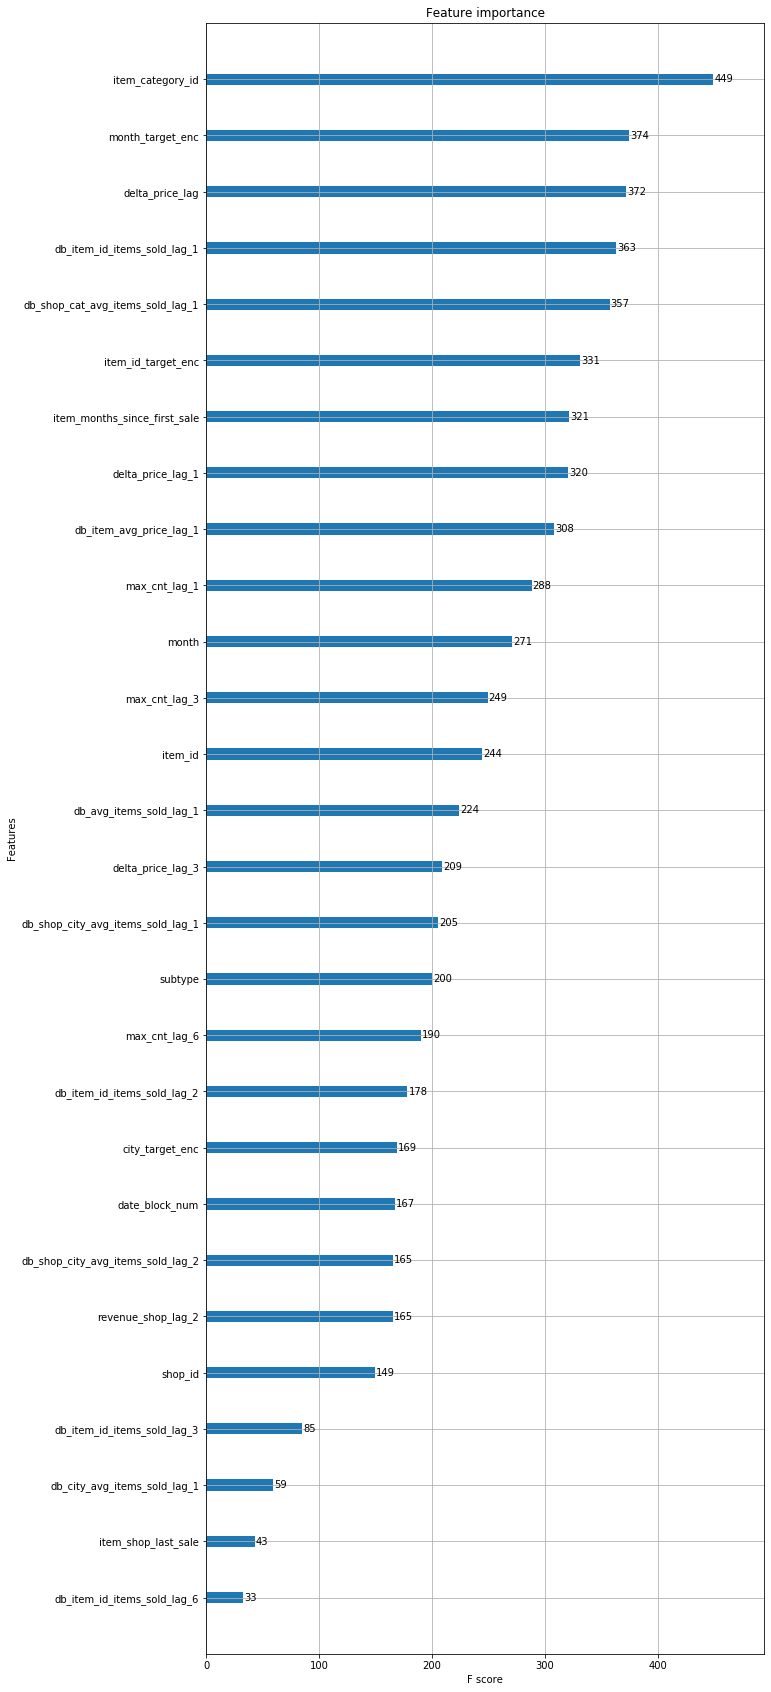

In [11]:
#base model-1

xgb = XGBRegressor(
    max_depth=8,
    n_estimators=45,
    min_child_weight=300, 
    colsample_bytree=0.9, 
    subsample=0.8, 
    eta=0.3,    
    seed=4)

xgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
        eval_metric = 'rmse', early_stopping_rounds =10,verbose=True)

predict(xgb,'xgb')

plot_features(xgb, (10,30))

'''



model1_train = xgb.predict(X_train)
model1_valid = xgb.predict(X_valid)
model1_test = xgb.predict(X_test)


del xgb
gc.collect();

#base model-2
svr_model= SVR(kernel='rbf', degree=10, verbose=True, max_iter = 50)

svr_model.fit(X_train, Y_train)
model2_train = svr_model.predict(X_train)
model2_valid = svr_model.predict(X_valid)
model2_test = svr_model.predict(X_test)



del svr_model
gc.collect();

#base model-3
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.05, max_iter=100)
lasso.fit(X_train, Y_train)
model3_train = lasso.predict(X_train)
model3_valid = lasso.predict(X_valid)
model3_test = lasso.predict(X_test)


del lasso
gc.collect();

#stacking
base_predictions_train = pd.DataFrame( {'XGBoost': model1_train.ravel(),
     'SVR model': model2_train.ravel(),
     'lasso': model3_train.ravel()
     #'SVM': model4_train.ravel()
    })
base_predictions_test = pd.DataFrame( {'XGBoost': model1_test.ravel(),
     'SVR model': model2_test.ravel(),
     'lasso': model3_test.ravel()
     #'SVM': model4_test.ravel()
    })

base_predictions_valid = pd.DataFrame( {'XGBoost': model1_valid.ravel(),
     'SVR model': model2_valid.ravel(),
     'lasso': model3_valid.ravel()
     #'SVM': model4_valid.ravel()
    })

X_new_train = base_predictions_train.as_matrix()
X_new_valid = base_predictions_valid.as_matrix()
X_new_test = base_predictions_test.as_matrix()
base_predictions_train.head()

#heatmap to see correlation between different predictions
sns.heatmap(base_predictions_train.astype(float).corr(),
            linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
'''

In [12]:
'''
# META Model
lm = LinearRegression()
lm.fit(X_new_train,Y_train)
y_valid_pred = lm.predict(X_new_valid)
plt.plot(y_valid_pred, '.', Y_valid, 'x')
#y_test_pred = lm.predict(X_new_test)

Y_test = lm.predict(X_new_test).clip(0., 20.)
results = X_test.loc[:,['shop_id', 'item_id']]
results['prediction'] = Y_test
if len(test.columns)==3:
    test.drop('ID',axis=1,inplace=True)
sub = pd.merge(test, results, on = ['shop_id', 'item_id'], how='left')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": sub['prediction']
})
submission.to_csv('stack_submission.csv', index=False)
'''

'\n# META Model\nlm = LinearRegression()\nlm.fit(X_new_train,Y_train)\ny_valid_pred = lm.predict(X_new_valid)\nplt.plot(y_valid_pred, \'.\', Y_valid, \'x\')\n#y_test_pred = lm.predict(X_new_test)\n\nY_test = lm.predict(X_new_test).clip(0., 20.)\nresults = X_test.loc[:,[\'shop_id\', \'item_id\']]\nresults[\'prediction\'] = Y_test\nif len(test.columns)==3:\n    test.drop(\'ID\',axis=1,inplace=True)\nsub = pd.merge(test, results, on = [\'shop_id\', \'item_id\'], how=\'left\')\nsubmission = pd.DataFrame({\n    "ID": test.index, \n    "item_cnt_month": sub[\'prediction\']\n})\nsubmission.to_csv(\'stack_submission.csv\', index=False)\n'

In [13]:
'''
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    random_seed=63,
    iterations=200,
    learning_rate=0.12,
    depth=4,
    loss_function='RMSE',
    rsm = 0.85,
    od_type='Iter',
    od_wait=20,
)
model.fit(
    X_train, Y_train,
    logging_level='Silent',
    eval_set=(X_valid, Y_valid),
    plot=True
)

importances = model.get_feature_importance(prettified=True)
feature_labels = []
feature_value = []
for i in range(0,len(importances)):
    feature_labels.append(importances[i][0])
    feature_value.append(importances[i][1])
    
fig, ax = plt.subplots(1,1,figsize=(10,20))
sns.barplot(y = feature_labels,  x=feature_value, ax=ax)

predict(model,'catboost')
'''

"\nfrom catboost import CatBoostRegressor\n\nmodel = CatBoostRegressor(\n    random_seed=63,\n    iterations=200,\n    learning_rate=0.12,\n    depth=4,\n    loss_function='RMSE',\n    rsm = 0.85,\n    od_type='Iter',\n    od_wait=20,\n)\nmodel.fit(\n    X_train, Y_train,\n    logging_level='Silent',\n    eval_set=(X_valid, Y_valid),\n    plot=True\n)\n\nimportances = model.get_feature_importance(prettified=True)\nfeature_labels = []\nfeature_value = []\nfor i in range(0,len(importances)):\n    feature_labels.append(importances[i][0])\n    feature_value.append(importances[i][1])\n    \nfig, ax = plt.subplots(1,1,figsize=(10,20))\nsns.barplot(y = feature_labels,  x=feature_value, ax=ax)\n\npredict(model,'catboost')\n"